# FAISS Profiling
Analyzing various types of searches in FAISS.

In [1]:
import faiss
import numpy as np

from datasets import load_dataset

import jmagics

In [2]:
embeddings = load_dataset("Sreenath/million-text-embeddings", split="test")[:10_000]['embedding']
embeddings = np.array(embeddings, dtype=np.float32)
dimensions = len(embeddings[0])

K = 5

In [3]:
%%duration NORMALIZE
faiss.normalize_L2(embeddings)

Duration:  2.3 ms


In [4]:
embeddings_norm = embeddings
query_norm = embeddings_norm[99:100]

### Search Using HNSW

In [5]:
%%duration HNSW_INDEXING
hnsw_index = faiss.IndexHNSWFlat(dimensions, 32, faiss.METRIC_INNER_PRODUCT)
hnsw_index.add(embeddings_norm)

Duration:  159 ms


In [6]:
%%duration HNSW_SEARCHING
hnsw_index.search(query_norm, K)

Duration:  175 μs


(array([[1.0000001 , 0.58241963, 0.52046716, 0.5198934 , 0.49409175]],
       dtype=float32),
 array([[  99, 5873, 7076, 1642, 5547]]))

### Search using FAISS FlatIP

In [7]:
%%duration FLAT_INDEXING
flat_index = faiss.IndexFlatIP(dimensions)
flat_index.add(embeddings_norm)

Duration:  2.75 ms


In [8]:
%%duration FLAT_SEARCHING
flat_index.search(query_norm, K)

Duration:  542 μs


(array([[1.0000001 , 0.58241963, 0.52046716, 0.5198934 , 0.49409175]],
       dtype=float32),
 array([[  99, 5873, 7076, 1642, 5547]]))

### Search using FAISS IVF

In [9]:
%%duration IVF_INDEXING
clusters = 100
quantizer = faiss.IndexFlatIP(dimensions)
ivf_index = faiss.IndexIVFFlat(quantizer, dimensions, clusters, faiss.METRIC_INNER_PRODUCT)
ivf_index.train(embeddings_norm)
ivf_index.add(embeddings_norm)
ivf_index.nprobe = 10 #Number of clusters to search

Duration:  32.1 ms


In [10]:
%%duration IVF_SEARCHING
ivf_index.search(query_norm, K)

Duration:  181 μs


(array([[1.0000001 , 0.58241963, 0.52046716, 0.5198934 , 0.49409175]],
       dtype=float32),
 array([[  99, 5873, 7076, 1642, 5547]]))

### Search using FAISS LSH

In [11]:
%%duration LSH_INDEXING
n_bits = 32  # Number of hash bits
lsh_index = faiss.IndexLSH(dimensions, n_bits)
lsh_index.add(embeddings_norm)

Duration:  1.61 ms


In [12]:
%%duration LSH_SEARCHING
lsh_index.search(query_norm, K)

Duration:  236 μs


(array([[0., 5., 5., 5., 6.]], dtype=float32),
 array([[  99, 6179, 7629, 8744, 1564]]))

## Results

Corpus size: 10000
Linear Scale:


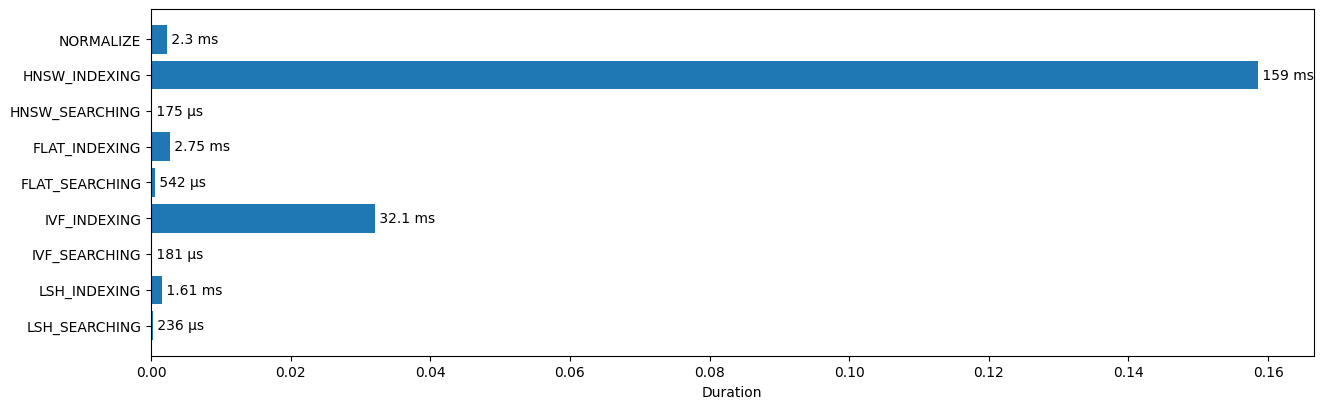


Logarithmic Scale:


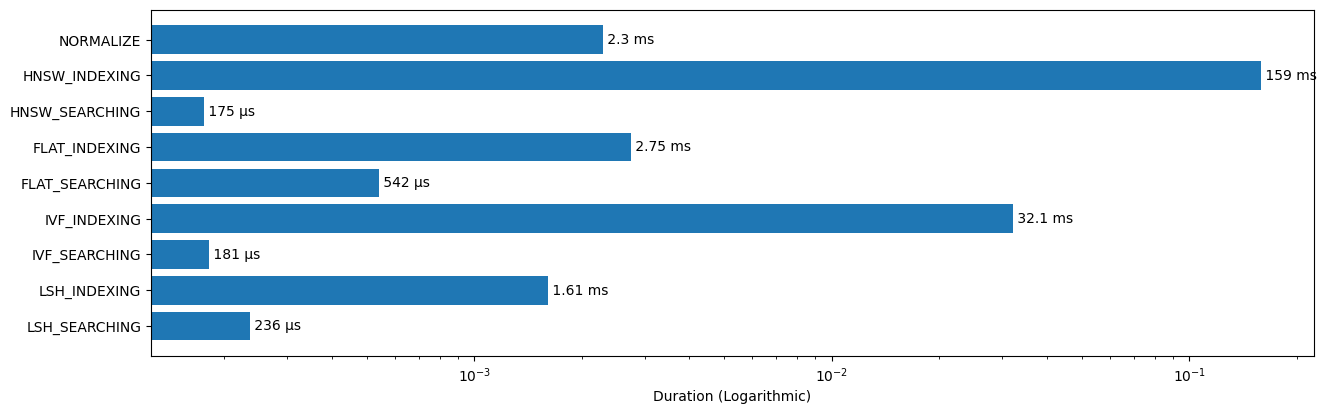


System Information:
-------------------
Processor: Apple M3 Max
Architecture: ARM_8
Bits: 64
Uname: Darwin
Cores (Logical): 16
Cores (Physical): 16
Total RAM: 128.0 GB
GPU information not available.


In [13]:
print("Corpus size:", len(embeddings))

print("Linear Scale:")
%plot_durations

print("Logarithmic Scale:")
%plot_durations log

%print_sysinfo